<a href="https://colab.research.google.com/github/NilsBahr94/Master_Thesis_Algorithmic-Bias-in-AI/blob/Develop/Master_Thesis_Algorithmic_Bias_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Import packages

### Basic 

In [0]:
# Install relevant libraries
!pip install plotnine  
!pip install pandas
!pip install plotly

In [0]:
# Basic Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from plotnine import *

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Learning Curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

### Fairness Tools

In [0]:
# Installation

!pip install aif360
# https://github.com/IBM/AIF360/blob/master/examples/README.md

!pip install aequitas
# https://github.com/dssg/aequitas

!pip install audit-AI
# https://github.com/pymetrics/audit-ai

!pip install responsibly
# https://docs.responsibly.ai/

In [0]:
# Import

import aif360
import aequitas
import auditai
import responsibly

ImportError: ignored

### What-If Tool

In [0]:
# Install current tensorflow version

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

In [0]:
# Install the What-If Tool
try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [0]:
# Define Helper Functions for the What-If tool
import pandas as pd
import numpy as np
import witwidget

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

# Case Studies

**Criteria for Dataset Selection**

https://www.notion.so/techlabs/Master-Thesis-Proposal-c1550763e23c485887147f59cebc695d#350e14b5c061432189b80eb1df2a81c5

## 1) US Adult Income Dataset

### Data Import

In [0]:
# Import dataset and convert to Pandas Dataframe 

# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df_3_adult = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

### Exploratory Data Analysis 1

*Outcomes*:

1. Understanding of the general structure of the dataset
2. Understanding of basic statistics of the features of the dataset 


In [0]:
df_3_adult.head(n=5)

In [0]:
# Number of rows and features
df_3_adult.shape

(32561, 15)

In [0]:
# List of specific features
df_3_adult.columns

In [0]:
# Datatypes of features
print(df_3_adult.dtypes)

In [0]:
df_3_adult.info

In [0]:
df_3_adult.describe()

**Summary of results**

1. Understanding of the general structure 
- Result: 
2. Understanding of basic statistics of the features of the  the dataset 
- Result: 



### Data Preprocessing 1

**Outcomes**:

- Data Types of features are in a correct data type format

In [0]:
# Data Type Conversion
# Template

df["C"] = df["C"].astype("float")
df["C"] = df["C"].astype("int")
df["C"] = df["C"].astype("object")


### Exploratory Data Analysis 2

**Outcomes**:

1. Identification of **features** on the basis of which subpopulations can be identified and discrimination can happen
2. Identification of **values** of these features that are connected to certain subpopulations
3. Identification of the percentage of certain subpopulation based on the values of these features -> *Sample Size Disparity I*
4. Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset -> *Sample Size Disparity II*
5. Identification of the target feature and the type of class balance
6. Identification of percentage of missing values per feature
7. Identification of severity of outliers per feature

1) **Identification of features on the basis of which subpopulations can be identified and discrimination can happen**

-> ***Race, Sex, Country, Workclass***

In [0]:
print(df_3_adult.columns)
print(df_3_adult.columns.nunique())

2) **Identification of values of these features that are connected to certain subpopulations**

In [0]:
# Race
print(df_3_adult.Race.unique())
print(df_3_adult.Race.nunique())

['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
5


In [0]:
# Sex
print(df_3_adult.Sex.unique())
print(df_3_adult.Sex.nunique())

['Male' 'Female']
2


In [0]:
# Country
print(df_3_adult.Country.unique())
print(df_3_adult.Country.nunique())

In [0]:
# Workclass
print(df_3_adult.Workclass.unique())
print(df_3_adult.Workclass.nunique())

In [0]:
# Education
print(df_3_adult.Education.unique())
print(df_3_adult.Education.nunique())

In [0]:
# Template for Group By Statistics 
print(df_3_adult.groupby("Race")["Capital-Gain"].agg([min, max, "mean"])) 

# print(df_3_adult.groupby(["Sex", "Race"])["Capital-Gain"].mean())

                    min    max         mean
Race                                       
Amer-Indian-Eskimo    0  27828   625.266881
Asian-Pac-Islander    0  99999  1478.358037
Black                 0  99999   609.940461
Other                 0  99999   934.660517
White                 0  99999  1121.660375
Sex     Race              
Female  Amer-Indian-Eskimo     544.605042
        Asian-Pac-Islander     778.436416
        Black                  516.593569
        Other                  254.669725
        White                  573.610391
Male    Amer-Indian-Eskimo     675.260417
        Asian-Pac-Islander    1827.813853
        Black                  702.454430
        Other                 1392.185185
        White                 1368.674455
Name: Capital-Gain, dtype: float64


`Interim Conclusion regarding 2) `

Mainly *Race* as well as *Sex* are the features on the basis of which discrimination could happen.

3) **Identification of the percentage of certain subpopulation based on the values of these features** -> *Sample Size Disparity I*

In [0]:
# Absolute number of members of different "races"
print(df_3_adult.Race.value_counts(dropna=False, sort=True)) # Learning: würde genauso mit df_3_adult["Race"].value_counts(dropna=False) funktionieren

# Percentage of members of different "races"
print(df_3_adult.Race.value_counts(normalize=True, dropna=False, sort=True))

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: Race, dtype: int64
White                 0.854274
Black                 0.095943
Asian-Pac-Islander    0.031909
Amer-Indian-Eskimo    0.009551
Other                 0.008323
Name: Race, dtype: float64


In [0]:
# Visualization

(ggplot(df_3_adult)         # defining what data to use
 + aes(x='Race')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)

In [0]:
# Absolute number of members of different "sexes"
print(df_3_adult.Sex.value_counts(dropna=False, sort=True))

# Percentage of members of different "sexes"
print(df_3_adult.Sex.value_counts(normalize=True, dropna=False, sort=True))

`Interim conclusion regarding 3)`



4) **Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset** -> *Sample Size Disparity II*

In [0]:
# Count
df_3_adult.groupby(['Sex', 'Race']).agg({"Over-50K": 'count'})

In [0]:
# Alternative Count
df_3_adult_aggr = df_3_adult
df_3_adult_aggr['counting']=1
# df_3_adult_aggr.groupby(['Sex', 'Race']).agg({"counting": 'count'})

# To Do -> Jeweils verrechnen mit Grundgesamtheit von Subpopulationen

In [0]:
# Plot Alternative 1
fig = px.bar(df_3_adult_aggr, x="Race", y="counting", color='Sex', barmode='group')
fig.show()

In [0]:
# Plot Alternative 2
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
    go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

5) **Identification of the target feature and the type of class balance**

In [0]:
print(df_3_adult["Over-50K"].value_counts(dropna=False))
print(df_3_adult["Over-50K"].value_counts(normalize=True, dropna=False))

0    24720
1     7841
Name: Over-50K, dtype: int64
0    0.75919
1    0.24081
Name: Over-50K, dtype: float64


6) **Identification of percentage of missing values per feature**

In [0]:
print(df_3_adult.isna().any())
print(df_3_adult.isna().sum())

In [0]:
def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [0]:
assess_NA(df_3_adult)

`Interim conclusion on 6)`

No problems with NA

**To Do**: Determine if NA are encrypted in different format.

7) **Identification of severity of outliers per feature**

Show boxplot per numeric feature

In [0]:
df_3_adult.info()

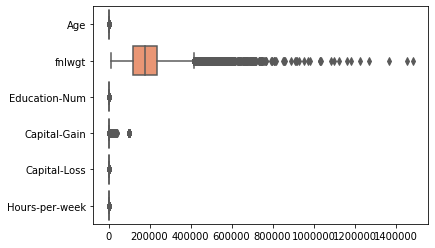

In [0]:
# Overview boxplot of all numerical features 
ax = sns.boxplot(data=df_3_adult, orient="h", palette="Set2")

In [0]:
# Age Boxplot
fig = px.box(df_3_adult, y="Age")
fig.show()

In [0]:
# Education Num
fig = px.box(df_3_adult, y="Education-Num")
fig.show()

In [0]:
# Capital Gain
fig = px.box(df_3_adult, y="Capital-Gain")
fig.show()

In [0]:
# Capital Loss
fig = px.box(df_3_adult, y="Capital-Loss")
fig.show()

In [0]:
# Hours per Week
fig = px.box(df_3_adult, y="Hours-per-week")
fig.show()

#### Analysis with the What-If Tool

Guide: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/xgboost_caip.ipynb?hl=de


In [0]:
# Initialization of the What-If Tool

PROJECT_ID = 'YOUR_PROJECT_ID'
MODEL_NAME = 'YOUR_MODEL_NAME'
VERSION_NAME = 'YOUR_VERSION_NAME'
TARGET_FEATURE = 'mortgage_status'
LABEL_VOCAB = ['denied', 'approved']

config_builder = (WitConfigBuilder(test_examples.tolist(), features.columns.tolist() + ['mortgage_status'])
  .set_ai_platform_model(PROJECT_ID, MODEL_NAME, VERSION_NAME, adjust_prediction=adjust_prediction)
  .set_target_feature(TARGET_FEATURE)
  .set_label_vocab(LABEL_VOCAB))

### Data Preprocessing 2

Tasks:
1. Convert the labels of the target variable into a suitable  format (binary integer)
2. Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy coding)
3. Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that (*TBD if really the right approach*)


1) Convert the labels of the target variable into a suitable  format (binary integer)

In [0]:
# Encoding Binary Variables

df_3_adult["Over-50K"] = df_3_adult["Over-50K"].apply(lambda val:
1 if val == ">50K" else 0)

In [0]:
df_3_adult["Over-50K"].dtypes

dtype('int64')

2) Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy encoding)

In [0]:
# Dummy 

df_3_adult_dummies = pd.get_dummies(df_3_adult)

3) Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that

In [0]:
# Setup filter
is_female = df_3_adult[df_3_adult["Sex"] == "Female"] 
is_black = df_3_adult[df_3_adult["Race"] == "Black"] 
# is_black_or_brown = dogs["color"].isin(["Black", "Brown"]) -> Template

# Create filtered version of the dataset
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]

# Intersectional 
# df_3_adult[is_female & is_black]


ValueError: ignored

### Modeling

In [0]:
# Import relevant modules and libraries

from sklearn.tree import DecisionTreeClassifier
# Import train_test_split
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score

#### Prototype Modeling I (k-NN)

k-NN ist rather suitable for sparse data.

https://www.notion.so/techlabs/Master-Thesis-Proposal-c1550763e23c485887147f59cebc695d#37c51e23d3554eefb8510d3e89e9d357

In [6]:
# Prepare datasets for train/test split

# Features of complete dataset
print(df_3_adult.columns)

# Input features
df_3_adult_train_input = df_3_adult_dummies.drop(columns=["Over-50K"])
print(df_3_adult_train_input.columns)

# Target feature
df_3_adult_train_label = df_3_adult_dummies["Over-50K"]
print(df_3_adult_train_label)

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Country',
       'Over-50K'],
      dtype='object')
Index(['Age', 'fnlwgt', 'Education-Num', 'Capital-Gain', 'Capital-Loss',
       'Hours-per-week', 'Workclass_?', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked',
       ...
       'Country_Portugal', 'Country_Puerto-Rico', 'Country_Scotland',
       'Country_South', 'Country_Taiwan', 'Country_Thailand',
       'Country_Trinadad&Tobago', 'Country_United-States', 'Country_Vietnam',
       'Country_Yugoslavia'],
      dtype='object', length=108)
0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Over-50K, Length: 32561, dtype: int64


In [0]:
# Train/test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_3_adult_train_input, 
                                                    df_3_adult_train_label, 
                                                    test_size=0.3, 
                                                    random_state=21) # seed for random number generator

**Possible Classification Scoring Metrics** 	 

‘accuracy’        	sklearn.metrics.accuracy_score
‘average_precision’	sklearn.metrics.average_precision_score
‘f1’	              sklearn.metrics.f1_score
‘precision’       	sklearn.metrics.precision_score
‘recall’	          sklearn.metrics.recall_score
‘roc_auc’	          sklearn.metrics.roc_auc_score

Option to calculate own scoring: https://scikit-learn.org/0.15/modules/model_evaluation.html#implementing-your-own-scoring-object

In [0]:
# Train Algorithm - Cross Validation
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier

# Setup
knn = KNeighborsClassifier(n_neighbors=6) # To Do: Check appropriatness of hyperparameter
# Train
knn.fit(df_3_adult_train_input, df_3_adult_train_label)

scores = cross_val_score(knn, df_3_adult_train_input, df_3_adult_train_label,  
                         scoring = "f1", cv = 10) # To Do: Change metric

In [0]:
# Train algorithm - Train/Test Split

# Setup
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6) # To Do: Check appropriatness of hyperparameter

# Train
knn.fit(X_train, y_train)

# Predict
# y_pred = knn.predict(X_test)

# Cross-validated predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(knn, X_train, y_train, cv = 10) # Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (S.86). O'Reilly Media. Kindle-Version. 


In [10]:
# Get Basic Performance Statistics

# Confusion Matrix

from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train, y_train_pred)


array([[16785,   546],
       [ 4181,  1280]])

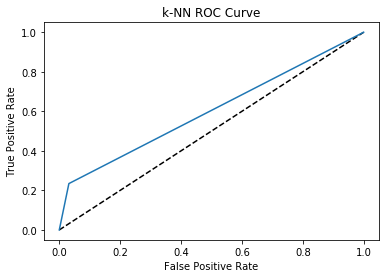

0.6014425325162005


In [11]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred) # Validate if the correct data was used
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='k-NN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('k-NN ROC Curve')
plt.show();

# AUC 
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_train_pred)) # Validate if the correct data was used


Save model for later investigation.

In [0]:
# Template Code to save models

# from sklearn.externals import joblib joblib.dump(my_model, "my_model.pkl") 
# my_model_loaded = joblib.load(" my_model.pkl")

**Learning Curve**

Version 1

In [0]:
# Define Learning Curve Function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

Automatically created module for IPython interactive environment


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

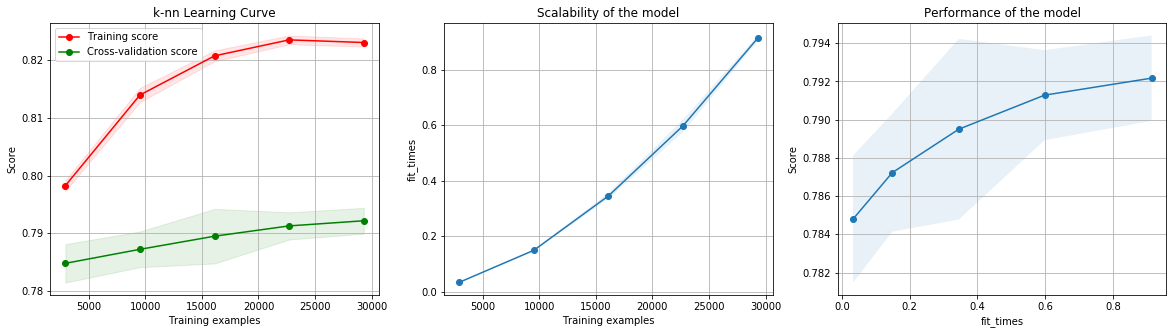

In [0]:
plot_learning_curve(estimator=knn, title="k-nn Learning Curve", X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    axes=None, ylim=None, cv=10,
                    n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

Version 2

https://www.dataquest.io/blog/learning-curves-machine-learning/

Mean training scores

 2604     0.793932
8465     0.814578
14326    0.819098
20187    0.821737
26048    0.821844
dtype: float64

 --------------------

Mean validation scores

 2604     0.783391
8465     0.786923
14326    0.789533
20187    0.790516
26048    0.792390
dtype: float64


(0, 1)

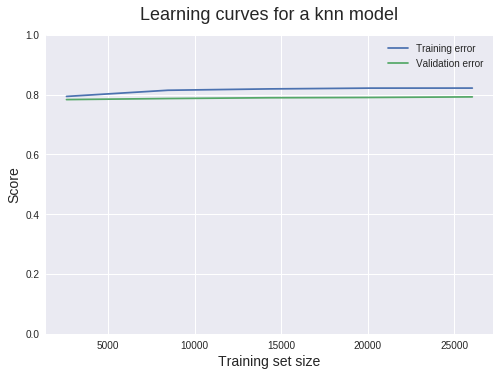

In [0]:
# train_sizes = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

from sklearn.model_selection import learning_curve

# features = df_3_adult_train_input.columns
# target = df_3_adult_train_label

train_sizes, train_scores, validation_scores = learning_curve(estimator = knn, 
                                                              X = df_3_adult_train_input, 
                                                              y = df_3_adult_train_label, 
                                                              cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a knn model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

In [18]:
print(df_3_adult_train_input.columns)
print(df_3_adult_train_label)

Index(['Age', 'fnlwgt', 'Education-Num', 'Capital-Gain', 'Capital-Loss',
       'Hours-per-week', 'Workclass_?', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked',
       ...
       'Country_Portugal', 'Country_Puerto-Rico', 'Country_Scotland',
       'Country_South', 'Country_Taiwan', 'Country_Thailand',
       'Country_Trinadad&Tobago', 'Country_United-States', 'Country_Vietnam',
       'Country_Yugoslavia'],
      dtype='object', length=108)
0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Over-50K, Length: 32561, dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



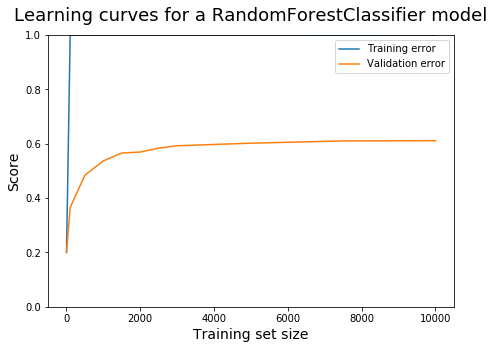

In [25]:
### Bundling our previous work into a function ###
train_sizes = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, data[features], data[target], train_sizes = train_sizes,
        cv = cv, scoring = 'recall')
    
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize = (16,5))

for model, i in [(RandomForestClassifier(), 1)]:
    plt.subplot(1,2,i)
    learning_curves(estimator = model, 
                    data = df_3_adult_dummies, 
                    features = df_3_adult_train_input.columns, 
                    target= "Over-50K", 
                    train_sizes = train_sizes, 
                    cv= 5)

# for model, i in [(RandomForestClassifier(), 1), (KNeighborsClassifier(),2)]:
#     plt.subplot(1,2,i)
#     learning_curves(estimator = model, 
#                     data = df_3_adult_dummies, 
#                     features = df_3_adult_train_input.columns, 
#                     target= "Over-50K", 
#                     train_sizes = train_sizes, 
#                     cv= 5)

In [0]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

#### Prototype Modeling II (Random Forest)

Random Forest is rather suitable for rich datasets.

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs =-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)


NameError: ignored

In [0]:
# Feature Importance for Random Forest

for i, item in enumerate(rfr.feature_importances_):
  print("{0:s}: {1:.2f}".format(X.columns[i], item))

#### Training

Choice of Training Algorithm:
- SVM
- ANN
- Random Forest
- Boosted Trees
- Logistic Regression
- CART Decision Tree
- k-NN
- Naive Bayes

Tasks:

1. Train model with a defined set of hyperparameters

#### Testing

#### Model Evaluation

1. Understand the predictive ability of the features
2. Understand class separability
3. Understand the structure of the subpopulation


1) Understand the predictive ability of the features

See *Chapter 18.2 Categorical Outcomes* in *Applied Predictive Modeling*.

Approaches:

- Plot ROC Curve per predictor variable 
- See metrics such as p-value and gain ratio 
- Relief algorithm


### Learning Curve

See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-download-auto-examples-model-selection-plot-learning-curve-py

In [0]:
# Define Learning Curve Function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

Automatically created module for IPython interactive environment


## 2) COMPAS Dataset

See: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_COMPAS.ipynb#scrollTo=67DYIFxoevt2

### Data Import

In [0]:
# Read training dataset from CSV

# TO DO: Check if dataset from link below matches dataset from Github repository: https://github.com/propublica/compas-analysis/

df_1_compas = pd.read_csv('https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv')
df_1_compas


### Exploratory Data Analysis 1

In [0]:
# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

%matplotlib inline

(ggplot(data = mpg)         # defining what data to use
 + aes(x='class')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)

#### Analysis with What-If Tool

### Data Preprocessing

To Do's:

- Filter Dataset based on the Subpopulations

### Exploratory Data Analysis 2

### Modeling

In [0]:
# Split into training and test set

#### Training

#### Testing & Model Evaluation

Inspiration: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_Age_Regression.ipynb#scrollTo=jlwjF-Nnmoww

In [0]:
# Installation of the What-If Tool

try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [0]:
# Define helper functions

import pandas as pd
import numpy as np
import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64) or df[f].dtype is np.dtype(np.int32):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64) or df[col].dtype is np.dtype(np.int32):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

Hint

## 3) Homicide Dataset

### Data Import

In [0]:
from google.colab import files
uploaded = files.upload()

Saving 2_Homicides_database.csv to 2_Homicides_database (2).csv


In [0]:
import _io
df_2_homicide = pd.read_csv(io.StringIO(uploaded['2_Homicides_database (2).csv'].decode('utf-8')))
df_2_homicide

In [0]:
# Initialize Data Import option 

from google.colab import drive
drive.mount('/content/drive')

In [0]:
path = "https://drive.google.com/open?id=1x27KDf6_fgqYHwccAb6U4h3HAh60eK2z"
df_2_homicide = pd.read_csv(path)
# Dataset is now stored in a Pandas Dataframe

### Exploratory Data Analysis 1

### Data Preprocessing

### Exploratory Data Analysis 2

### Modeling

## 4) German Credit Dataset

![alt text](https://)

### Data Import

In [0]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]  # TO DO

# Read the dataset from the provided CSV and print out information about it.
df_4_german = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df_4_german

## 5) Communities and Crime Dataset

### Data Import

In [0]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"] # TO DO

# Read the dataset from the provided CSV and print out information about it.
df_5_communities = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df_5_communities

# Generalizable Rule 

## Learning Curves

Helpful Links: 

-   https://github.com/laxmimerit/Learning-Curve-Machine-Learning-in-Python-KGP-Talkie/blob/master/Learning%20Curve%20Machine%20Learning%20in%20Python%20KGP%20Talkie.ipynb -> Learning Curve Tutorial
-   https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
-   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html



In [0]:
# Import all relevant packages and modules

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

### Templates

**Learning Curve Variant 1**



In [0]:
# Define plot_curve function

def plot_curve():
    # instantiate
    lg = LinearRegression()

    # fit
    lg.fit(X, y)
    
    
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    train_sizes, train_scores, test_scores = learning_curve(lg, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("RandomForestClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

Compared to the theory we covered, here our y-axis is 'score', not 'error', so the higher the score, the better the performance of the model.

Training score (red line) decreases and plateau
Indicates underfitting
High bias
Cross-validation score (green line) stagnating throughout
Unable to learn from data
Low scores (high errors)
Should tweak model (perhaps increase model complexity)

**Learning Curve Variant 2**

In [0]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Implementation on Case Study Datasets